In [1]:
# Calculations of accretion rates for Bondi-Hoyle-Lyttleton (BHL) 
# accretion model used in reference papaer M. Ricotti et al. 
# https://arxiv.org/abs/0709.0524 and Park Ricotti Model (PR)
# accretion model as per F. Scarcella et al. 2020, 
# https://arxiv.org/abs/2012.10421 . 


# Here, the value of the speed of sound in the ioinized region of 
# PR Model is chosen as c_s,in = 25 c_s. c_s,in is the free parameter 
# of PR accretion Model.


# The values of v_pbh, c_s and v_eff are used as per 
# Vivian Poulin & Pasquale D. Serpico et al. 2007 
# https://arxiv.org/abs/1707.04206. 



from scipy.integrate import quad
import numpy as np
from scipy.integrate import odeint
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import integrate
import matplotlib.ticker
from PRaccretion import*
import math
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


def c_s(z):
    return c_s_Serpico(z)

def v_pbh(z):
    return v_L_Serpico(z)

def v_eff(z):
    return v_eff_Serpico(z)



def x_e(z):
    if z < z_rec:
        return e_fraction
    else:
        return 1

    
def λ(z, m):
    def β_cap(z, m):
        return 1e-4 * m * (((1+z)/1000)**(3/2)) * (((5.74e3 * (yr/pc))/v_eff(z))**3) * (0.257 + 1.45 * (x_e(z)/0.01) * (((1+z)/1000)**(5/2)))
    def x_cr(z, m):
        return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m) 
    return np.exp((9/2)/(3 + β_cap(z, m)**(0.75))) * (x_cr(z, m)**2)



def M_dot_BHL(z, m):
    return (4 * np.pi * λ(z, m) * ((G * m)**2) * ρ(z))/(v_eff(z)**(3))

def M_dot_BHL_by_dz(z, m):
    return M_dot_BHL(z, m) * (dt_dz(z))

def m_dot_BHL(z, m):
    return M_dot_BHL(z, m)/M_dot_Edd(z, m) 



  

def M_dot_PR(z, m):
    def c_s_in(z):
        return free_parameter * c_s(z)
    def v_R(z):
        return  2 * c_s_in(z)
    def v_D(z):
        return  (c_s(z)**2)/(2 * c_s_in(z))
    def Δ(z):
        return (((v_pbh(z)**2) + (c_s(z)**2))**2) - (4 * (v_pbh(z)**2) * (c_s_in(z)**2)) 
    def ρ_in_plus(z):
        return  ρ(z) * (((v_pbh(z)**2) + (c_s(z)**2) + np.sqrt(Δ(z)))/(2 * (c_s_in(z)**2)))
    def ρ_in_minus(z):
        return ρ(z) * (((v_pbh(z)**2) + (c_s(z)**2) - np.sqrt(Δ(z)))/(2 * (c_s_in(z)**2)))
    def ρ_in_0(z):
        return ρ(z) * (((v_pbh(z)**2) + (c_s(z)**2))/(2 * (c_s_in(z)**2)))
    def ρ_in(z):
        if v_pbh(z) <= v_D(z):
            return ρ_in_plus(z)
        elif v_D(z) < v_pbh(z) < v_R(z):
            return ρ_in_0(z)
        else:
            return ρ_in_minus(z)
    def v_in(z):
        if v_pbh(z) <= v_D(z):
            return (ρ(z)/ρ_in(z)) * v_pbh(z)
        elif v_D(z) < v_pbh(z) < v_R(z):
            return c_s_in(z)
        else:
            return (ρ(z)/ρ_in(z)) * v_pbh(z)
    def v_eff_in(z):
        return np.sqrt((v_in(z)**2) + (c_s_in(z)**2))
    return (4 * np.pi  * ((G * m)**2) * ρ_in(z))/(v_eff_in(z)**(3))



def M_dot_PR_by_dz(z, m):
    return M_dot_PR(z, m) * (dt_dz(z))

def m_dot_PR(z, m):
    return (M_dot_PR(z, m)/M_dot_Edd(z, m))

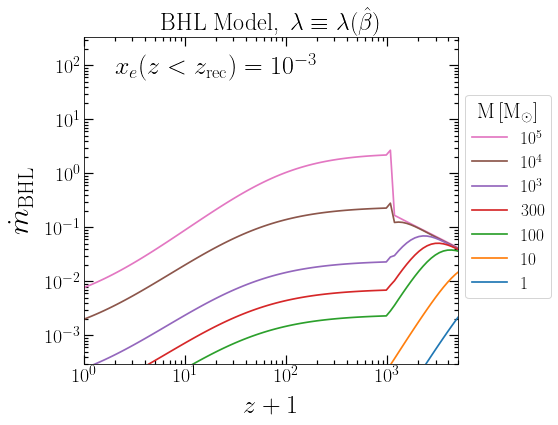

In [3]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_arr = np.zeros(len(z_array))


e_fraction = 1e-3
for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_arr[i] = m_dot_BHL(z, m)

    plt.loglog(z_array, m_dot_arr, color = color)
    

plt.text(2, 70, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 26, labelpad = 10)
plt.ylabel(' $\dot m_\mathrm{BHL} $', fontsize = 31, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend( ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$'], title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.2), prop = {"size":17.3})
plt.ylim(3e-4, 330)
plt.xlim(1, 5000)
plt.title(r'BHL Model, $\,\lambda \equiv \lambda(\hat \beta)$', fontsize = 24, pad = 8)
plt.savefig('Serp_m_dot_pbh_xe1e-3.pdf', bbox_inches = 'tight')
plt.show()

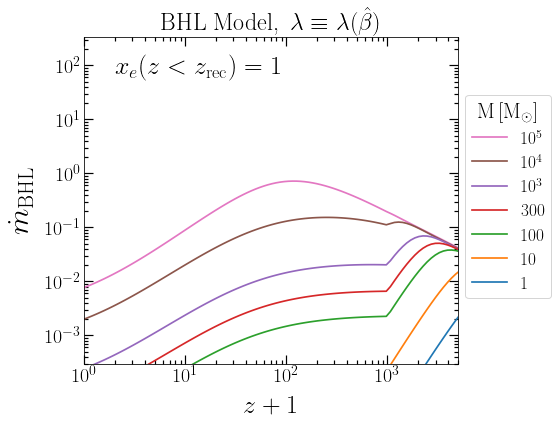

In [4]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_arr = np.zeros(len(z_array))


e_fraction = 1
for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_arr[i] = m_dot_BHL(z, m)

    plt.loglog(z_array, m_dot_arr, color = color)
    

plt.text(2, 70, '$x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 26, labelpad = 10)
plt.ylabel(' $\dot m_\mathrm{BHL} $', fontsize = 31, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend( ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$'], title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.2), prop = {"size":17.3})
plt.ylim(3e-4, 330)
plt.xlim(1, 5000)
plt.title(r'BHL Model, $\,\lambda \equiv \lambda(\hat \beta)$', fontsize = 24, pad = 8)
plt.savefig('Serp_m_dot_pbh_xe1.pdf', bbox_inches = 'tight')
plt.show()

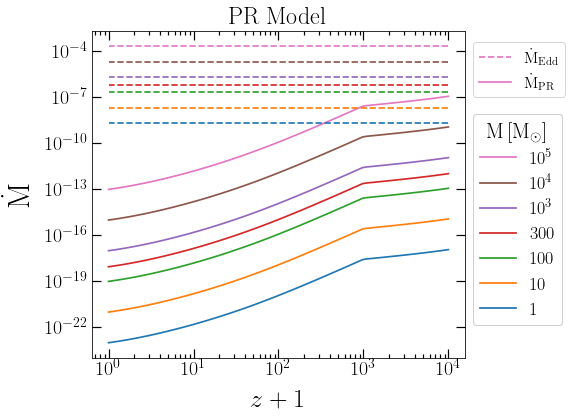

In [5]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
M_dot_arr = np.zeros(len(z_array))
M_dot_Edd_arr = np.zeros(len(z_array))

e_fraction = 1
free_parameter = 25
for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        M_dot_arr[i] = M_dot_PR(z, m)
        M_dot_Edd_arr[i] = M_dot_Edd(z, m)
    plt.loglog(z_array, M_dot_Edd_arr, color = color, ls= '--')
    plt.loglog(z_array, M_dot_arr, color = color)
    


plt.xlabel('$z+1$',  fontsize = 26, labelpad = 10)
plt.ylabel(' $\dot \mathrm{M}$', fontsize = 31, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "$ \mathrm{\dot M_{Edd}}$", "$ \mathrm{\dot M_{PR}}$"],
        title_fontsize = 21, loc = (1.02, 0.8), prop = {"size":16})
legend2 = plt.legend([lines[i] for i in [1, 3, 5, 7, 9, 11, 13]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.1), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.title('PR Model', fontsize = 24, pad = 8)
plt.savefig('M_dotPR_pbh_xe1.pdf', bbox_inches = 'tight')
plt.show()

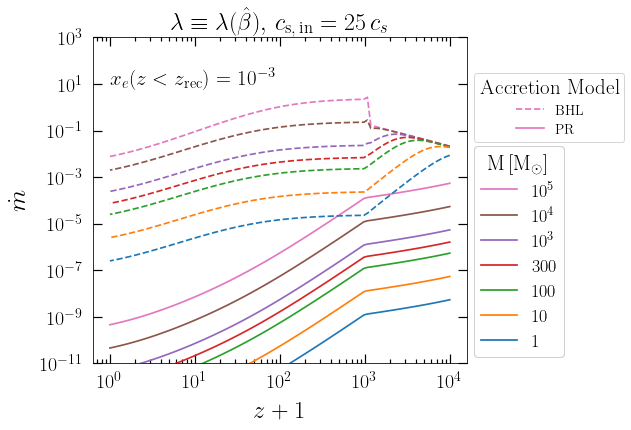

In [6]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_BHL_arr = np.zeros(len(z_array))
m_dot_PR_arr = np.zeros(len(z_array))



free_parameter = 25
e_fraction = 1e-3
for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_BHL_arr[i] = m_dot_BHL(z, m)
        m_dot_PR_arr[i] = m_dot_PR(z, m)
    
    
    plt.loglog(z_array, m_dot_BHL_arr, color = color, ls = '--')
    plt.loglog(z_array, m_dot_PR_arr, color = color)
    
plt.text(1, 10, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 21)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(' $\dot m$', fontsize = 26, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "BHL", "PR"], title = 'Accretion Model',
        title_fontsize = 21, loc = (1.02, 0.68), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [1, 3, 5, 7, 9, 11, 13]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.02), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.ylim(1e-11, 1000)
plt.title(r'$\,\lambda \equiv \lambda(\hat \beta), \, c_\mathrm{s,\, in} = 25 \, c_s$', fontsize = 24, pad = 8)
plt.savefig('Serp_m_dotPR_xe1e-3.pdf', bbox_inches = 'tight')
plt.show()

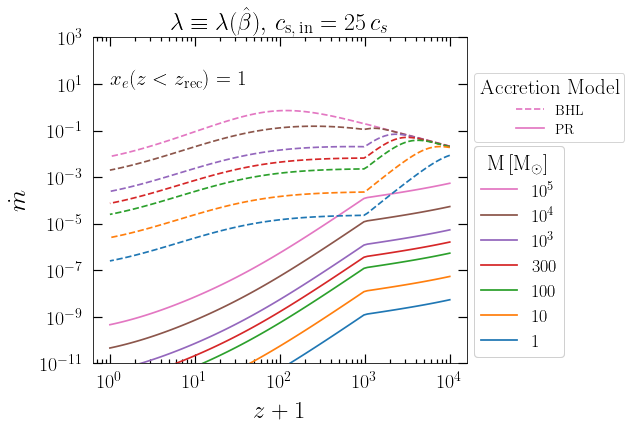

In [8]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')




mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_BHL_arr = np.zeros(len(z_array))
m_dot_PR_arr = np.zeros(len(z_array))



multiple = 25
e_fraction = 1
for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_BHL_arr[i] = m_dot_BHL(z, m)
        m_dot_PR_arr[i] = m_dot_PR(z, m)
    
    
    plt.loglog(z_array, m_dot_BHL_arr, color = color, ls = '--')
    plt.loglog(z_array, m_dot_PR_arr, color = color)
    
plt.text(1, 10, '$x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 21)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(' $\dot m$', fontsize = 26, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "BHL", "PR"], title = 'Accretion Model',
        title_fontsize = 21, loc = (1.02, 0.68), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [1, 3, 5, 7, 9, 11, 13]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.02), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.ylim(1e-11, 1000)
plt.title(r'$\,\lambda \equiv \lambda(\hat \beta), \, c_\mathrm{s,\, in} = 25 \, c_s$', fontsize = 24, pad = 8)
plt.savefig('Serp_m_dotPR_xe1.pdf', bbox_inches = 'tight')
plt.show()

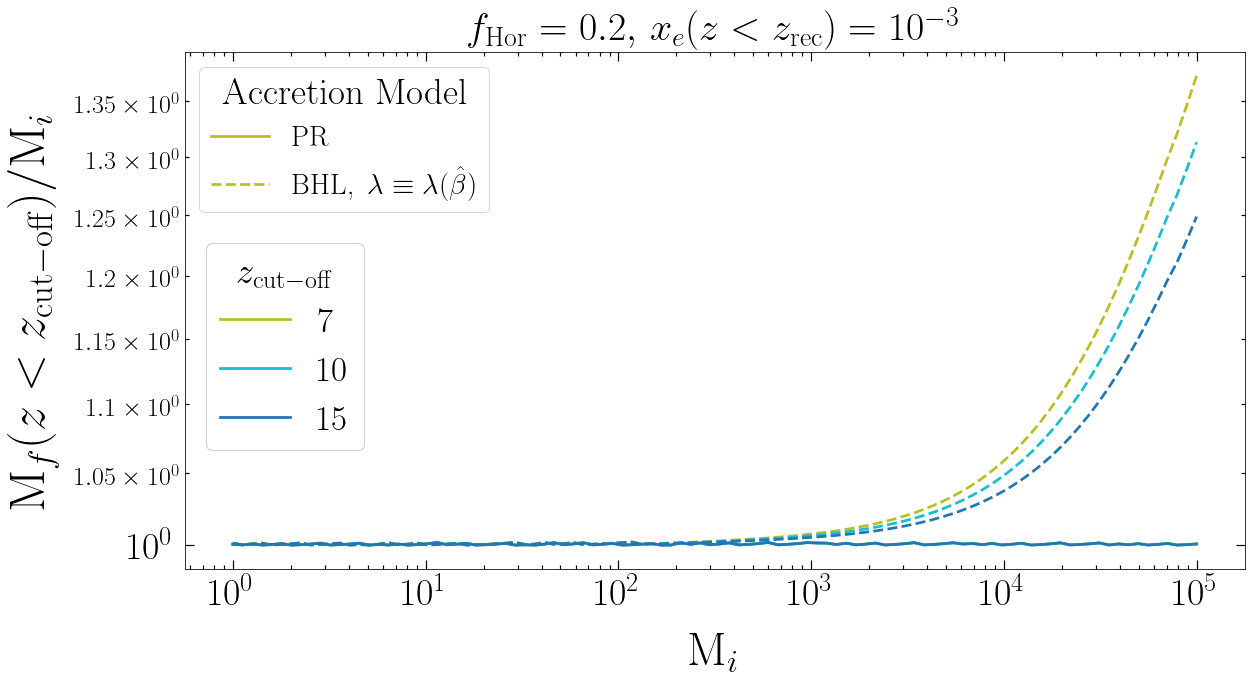

In [9]:
colors = ['C8', 'C9',  'C10']
fig,ax = plt.subplots(1, figsize = (19, 9.5))
plt.rc('lines', linewidth = 2.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.geomspace(1, 1e5, 100)
mf_arr_BHL = np.zeros(len(mi_arr))
mf_arr_PR = np.zeros(len(mi_arr))


N = 10
free_parameter = 25
e_fraction = 1e-3 


z_cut_arr = np.array([7, 10, 15])
for i, (z_cut, color) in enumerate(zip(z_cut_arr, colors)):
    for j, m in enumerate(mi_arr):
        f_Hor = 0.2
        z_1i =   1e20  #z_pbh_Ricotti(m, f_Hor)
        y_1i = m
        z_cut_off1 = z_eq
        t1 = np.geomspace(z_1i, z_cut_off1, N)
        sol1_BHL = solve_ivp(M_dot_BHL_by_dz, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        sol1_PR  = solve_ivp(M_dot_PR_by_dz, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        t1 = sol1_BHL.t
        y1_BHL = sol1_BHL.y[0]
        y1_PR = sol1_PR.y[0]

        
        z_2i = z_cut_off1
        y_2i_BHL = y1_BHL[-1]
        y_2i_PR  = y1_PR[-1]
        z_cut_off2 = z_rec
        t2 = np.geomspace(z_2i, z_cut_off2, N)
        sol2_BHL = solve_ivp(M_dot_BHL_by_dz, t_span = [t2[0], t2[-1]], y0 = [y_2i_BHL], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        sol2_PR  =  solve_ivp(M_dot_PR_by_dz, t_span = [t2[0], t2[-1]], y0 = [y_2i_PR], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        t2 = sol2_BHL.t
        y2_BHL = sol2_BHL.y[0]
        y2_PR = sol2_PR.y[0]



        z_3i = z_cut_off2
        y_3i_BHL = y2_BHL[-1]
        y_3i_PR  = y2_PR[-1]
        z_cut_off3 = z_cut
        t3 = np.geomspace(z_3i, z_cut_off3, N)
        sol3_BHL = solve_ivp(M_dot_BHL_by_dz, t_span = [t3[0], t3[-1]], y0 = [y_3i_BHL], method = 'DOP853', t_eval = t3, first_step = 5, max_step = 10)
        sol3_PR  = solve_ivp(M_dot_PR_by_dz, t_span = [t3[0], t3[-1]], y0 = [y_3i_PR], method = 'DOP853', t_eval = t3, first_step = 5, max_step = 10)
        t3 = sol3_BHL.t
        y3_BHL = sol3_BHL.y[0]
        y3_PR = sol3_PR.y[0]
        
        
        
        
        
        mf_arr_BHL[j] = y3_BHL[-1]
        mf_arr_PR[j]  = y3_PR[-1]
         
        
    
    ax.loglog(mi_arr, np.divide(mf_arr_PR, mi_arr), color = color) 
    ax.loglog(mi_arr, np.divide(mf_arr_BHL, mi_arr), color = color, ls = '--')
     
    
    
    
ax.tick_params(axis ='x', pad = 9.9)
ax.tick_params(axis ='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["PR", r"BHL, $\, \lambda \equiv \lambda(\hat \beta)$"], title = 'Accretion Model',
        title_fontsize = 37, loc = 'upper left', prop = {"size":29})
legend2 = plt.legend([lines[i] for i in [0, 2, 4]], ['$7$', r'$10$', 
           r'$15$'], title = '$z_\mathrm{cut-off} $',
           title_fontsize = 37, loc = (0.02, 0.23), prop = {"size":35})
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.tick_params(axis = 'y', which = 'minor', labelsize = 26)


plt.xticks(fontsize = 38)
plt.yticks(fontsize = 38)
plt.xlabel('$\mathrm{M}_{i}$',fontsize = 47, labelpad = 20)
plt.ylabel(r'$\mathrm{M}_{f}(z < z_\mathrm{cut-off})/\mathrm{M}_{i} $',fontsize = 50, labelpad = 16)
plt.xscale('log')
plt.title(r'$f_\mathrm{Hor} = 0.2, \, x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 40, pad = 13)
plt.savefig('Serp_PRacc_Ricotti_xe1e-3.pdf', bbox_inches = 'tight')
plt.show()

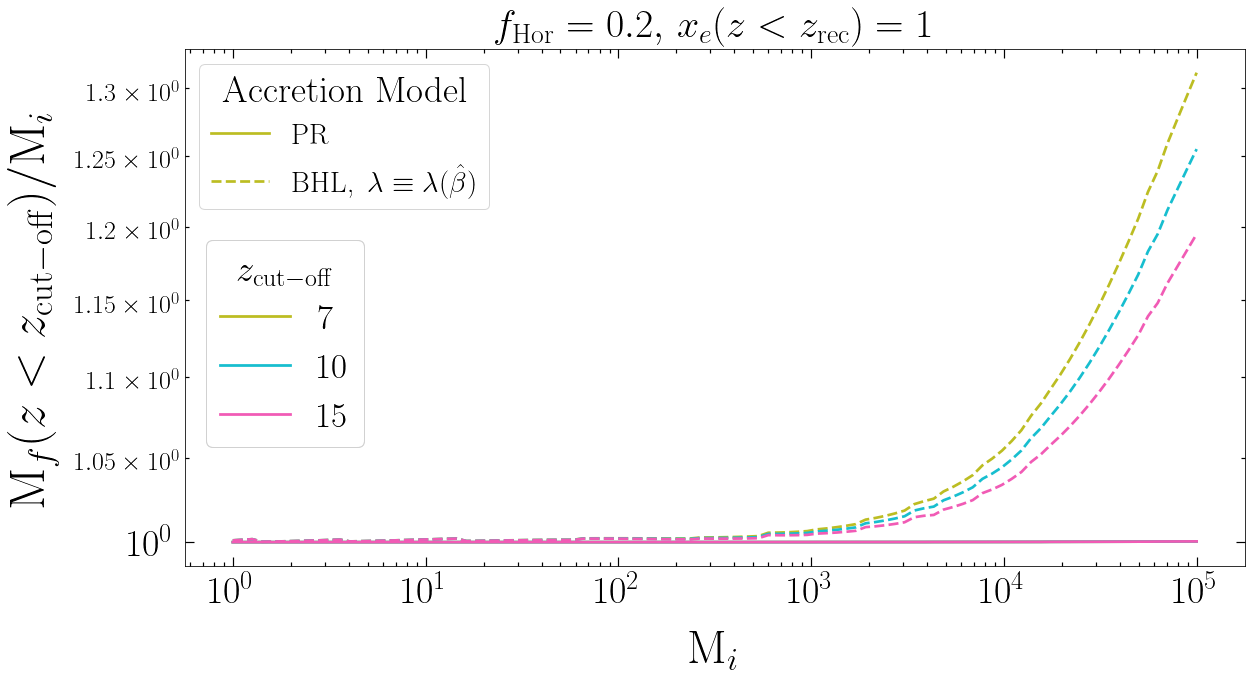

In [2]:
colors = ['C8', 'C9',  '#f15bb5']
fig,ax = plt.subplots(1, figsize = (19, 9.5))
plt.rc('lines', linewidth = 2.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.geomspace(1, 1e5, 100)
mf_arr_BHL = np.zeros(len(mi_arr))
mf_arr_PR = np.zeros(len(mi_arr))


N = 10
free_parameter = 25
e_fraction = 1
 

z_cut_arr = np.array([7, 10, 15])
for i, (z_cut, color) in enumerate(zip(z_cut_arr, colors)):
    for j, m in enumerate(mi_arr):
        f_Hor = 0.2
        z_1i = z_pbh_Ricotti(m, f_Hor)
        y_1i = m
        z_cut_off1 = z_eq
        t1 = np.geomspace(z_1i, z_cut_off1, N)
        sol1_BHL = solve_ivp(M_dot_BHL_by_dz, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        sol1_PR  = solve_ivp(M_dot_PR_by_dz, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        t1 = sol1_BHL.t
        y1_BHL = sol1_BHL.y[0]
        y1_PR = sol1_PR.y[0]

        
        z_2i = z_cut_off1
        y_2i_BHL = y1_BHL[-1]
        y_2i_PR  = y1_PR[-1]
        z_cut_off2 = z_rec
        t2 = np.geomspace(z_2i, z_cut_off2, N)
        sol2_BHL = solve_ivp(M_dot_BHL_by_dz, t_span = [t2[0], t2[-1]], y0 = [y_2i_BHL], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        sol2_PR  =  solve_ivp(M_dot_PR_by_dz, t_span = [t2[0], t2[-1]], y0 = [y_2i_PR], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        t2 = sol2_BHL.t
        y2_BHL = sol2_BHL.y[0]
        y2_PR = sol2_PR.y[0]



        z_3i = z_cut_off2
        y_3i_BHL = y2_BHL[-1]
        y_3i_PR  = y2_PR[-1]
        z_cut_off3 = z_dec
        t3 = np.geomspace(z_3i, z_cut_off3, N)
        sol3_BHL = solve_ivp(M_dot_BHL_by_dz, t_span = [t3[0], t3[-1]], y0 = [y_3i_BHL], method = 'DOP853', t_eval = t3, first_step = 5, max_step = 10)
        sol3_PR  =  solve_ivp(M_dot_PR_by_dz, t_span = [t3[0], t3[-1]], y0 = [y_3i_PR], method = 'DOP853', t_eval = t3, first_step = 5, max_step = 10)
        t3 = sol3_BHL.t
        y3_BHL = sol3_BHL.y[0]
        y3_PR = sol3_PR.y[0]
        
        
        
        z_4i = z_cut_off3
        y_4i_BHL = y3_BHL[-1]
        y_4i_PR  = y3_PR[-1]
        z_cut_off4 = z_cut
        t4 = np.geomspace(z_4i, z_cut_off4, N)
        sol4_BHL = solve_ivp(M_dot_BHL_by_dz, t_span = [t4[0], t4[-1]], y0 = [y_4i_BHL], method = 'DOP853', t_eval = t4, first_step = 1, max_step = 5)
        sol4_PR  =  solve_ivp(M_dot_PR_by_dz, t_span = [t4[0], t4[-1]], y0 = [y_4i_PR], method = 'DOP853', t_eval = t4, first_step = 1, max_step = 5)
        t4 = sol4_BHL.t
        y4_BHL = sol4_BHL.y[0]
        y4_PR = sol4_PR.y[0]
        
        mf_arr_BHL[j] = y4_BHL[-1]
        mf_arr_PR[j]  = y4_PR[-1]
         
        
    
    ax.loglog(mi_arr, np.divide(mf_arr_PR, mi_arr), color = color) 
    ax.loglog(mi_arr, np.divide(mf_arr_BHL, mi_arr), color = color, ls = '--')
     
    
    
    
ax.tick_params(axis ='x', pad = 9.9)
ax.tick_params(axis ='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["PR", r"BHL, $\, \lambda \equiv \lambda(\hat \beta)$"], title = 'Accretion Model',
        title_fontsize = 37, loc = 'upper left', prop = {"size":29})
legend2 = plt.legend([lines[i] for i in [0, 2, 4]], ['$7$', r'$10$', 
           r'$15$'], title = '$z_\mathrm{cut-off} $',
           title_fontsize = 37, loc = (0.02, 0.23), prop = {"size":35})
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.tick_params(axis = 'y', which = 'minor', labelsize = 26)
plt.xticks(fontsize = 38)
plt.yticks(fontsize = 38)
plt.xlabel('$\mathrm{M}_{i}$',fontsize = 47, labelpad = 20)
plt.ylabel(r'$\mathrm{M}_{f}(z < z_\mathrm{cut-off})/\mathrm{M}_{i} $',fontsize = 50, labelpad = 16)
plt.xscale('log')
plt.title(r'$f_\mathrm{Hor} = 0.2, \, x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 40, pad = 13)
plt.savefig('Serp_PRacc_Ricotti_xe1.pdf', bbox_inches = 'tight')
plt.show()

In [3]:
1/(10**(3/2))

0.03162277660168379

In [5]:
1/(5**(3/2))

0.08944271909999159

In [6]:
4 * np.sqrt(2) * 625

3535.533905932738